# RAG
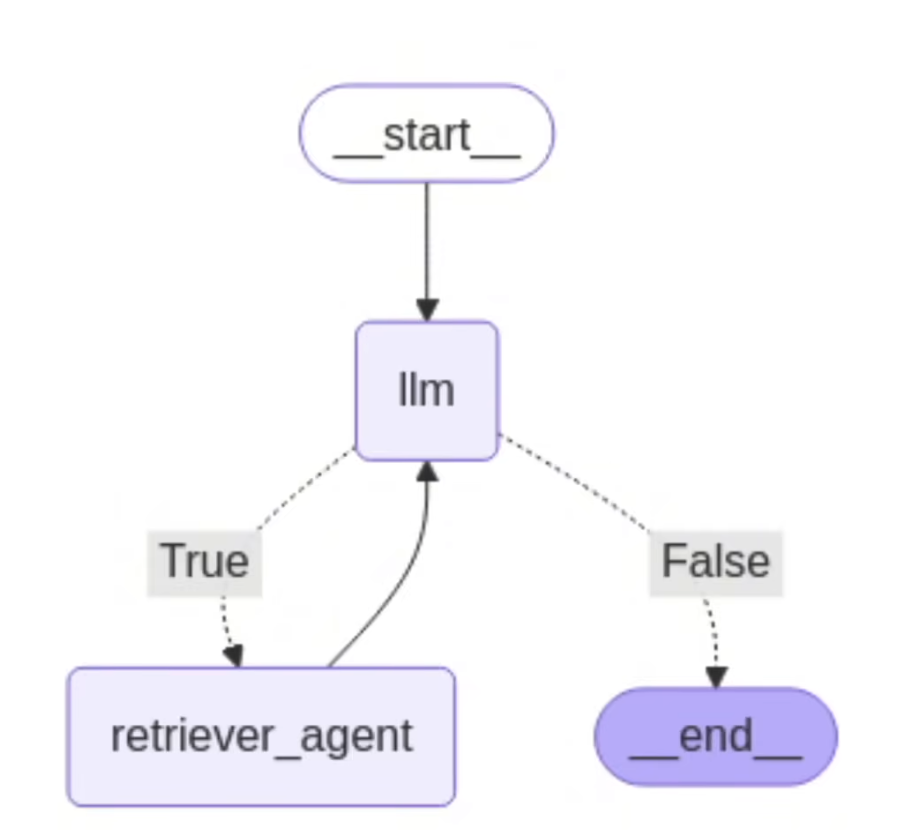

In [4]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

load_dotenv()

llm = ChatOpenAI(
    model="gpt-4o", temperature = 0) 
# I want to minimize hallucination - temperature = 0 makes the model output more deterministic 
# 0 - more deterministic
# 1 - more stocastic 

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

In [7]:
# load the files
pdf_path = "./Nikhil_Nageshwar_Inturi_cr.pdf"
if not os.path.exists(pdf_path):
    raise ValueError(f"File not found: {pdf_path}")
pdf_loader = PyPDFLoader(pdf_path)
pdf_loader.load()

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 17 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 35 0 (offset 0)


[Document(metadata={'producer': 'macOS Version 15.4 (Build 24E248) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': "D:20250505162904Z00'00'", 'moddate': "D:20250505162904Z00'00'", 'source': './Nikhil_Nageshwar_Inturi_cr.pdf', 'total_pages': 8, 'page': 0, 'page_label': '1'}, page_content='Nikhil Nageshwar Inturi +1 (945) 216-4026 | inturinikhilnageshwar@gmail.com | LinkedIn | Github:unikill066  SUMMARY: Data Scientist with 7+ years of experience specializing in Generative AI, Applied Machine Learning, and Bioinformatics with dual master’s degrees in Business Analytics & Artificial Intelligence and in Machine Learning and AI. Proven track record of designing and deploying innovative tools-including advanced neuron detection systems and scalable bioinformatics analysis pipelines-contributing to multiple high-impact research publications. Adept at end-to-end solution delivery: from data acquisition and statistical modeling to cloud-based deployment and visualization. Highly profici

In [ ]:
try:
    pages = pdf_loader.load()
    print("pages: ", len(pages))
except Exception as e:
    print("Error loading PDF:", str(e))


Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 17 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 35 0 (offset 0)


pages:  8


In [11]:
# chunking
test_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)
    
pages_split = test_splitter.split_documents(pages)

In [21]:
# os.getcwd()

In [ ]:
# vector database
persist_directory = "/path/to/Agents/chromadb"
collection_name = "nikhil"

if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)

try:
    vectorestore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name,
    )
    print('Created vector database')
except Exception as e:
    print(e)

Created vector database


In [24]:
# retriver
retriver = vectorestore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

@tool
def retriver_tool(query: str) -> str:
    """this tool searches and returns the info from the vector database"""
    docs = retriver.invoke(query)
    if not docs:
        return "I found no relevant information in the vector database"
    
    results = list()
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}: \n {doc.page_content}")
    
    return "\n".join(results)

tools = [retriver_tool]

llm = llm.bind_tools(tools)

In [25]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

def should_continue(state: AgentState):
    """check if the last message contains tool calls""" 
    result = state["messages"][-1]
    return hasattr(result, "tool_calls") and len(result.tool_calls) > 0

In [26]:
system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [30]:
tools_dict = {our_tool.name: our_tool for our_tool in tools}

def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)
    return {'messages': [message]}

def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
        
        if not t['name'] in tools_dict:
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")

        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}


In [32]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

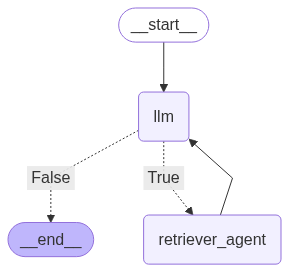

In [33]:
from IPython.display import display, Image
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [ ]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)]

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)

running_agent()


=== RAG AGENT===

=== ANSWER ===
I don't have information on Nikhil's experience with Python as it is not related to the stock market performance in 2024. My focus is on answering questions related to the stock market performance based on the provided document. If you have any questions about that, feel free to ask!
Calling Tool: retriver_tool with query: Nikhil work experience
Result length: 2049
Tools Execution Complete. Back to the model!

=== ANSWER ===
Nikhil worked at Infosys Limited, where he was involved in various projects and received the Infosys Insta Rise Award for exceptional crisis management and technical leadership during critical production incidents. He also worked on a project for a BMW client, designing and implementing a secure Java/Spring Boot invoicing application.

=== ANSWER ===
You're welcome! If you have any questions or need assistance, feel free to ask.
